# Predicting Well-Being From National Survey Data

## Table of contents
* [1. Background](#problem)
* [2. Data Cleaning](#data)
* [3. Exploratory Data Analysis](#eda)
     * [3.1 Visualizing the Data](#visuals)
     * [3.2 Final Cleaning](#finalclean)
     * [3.3 KNN Imputation](#impute)
* [4. Model Building](#model)
     * [4.1 Linear Regression](#lr)
     * [4.2 Support Vector Regression](#svr)
     * [4.3 K-Nearest Regression](#knr)
     * [4.4 Decision Tree and Random Forest Regression](#trees)
* [5. Dimensionality Reduction and Modeling](#dim)
     * [5.1 PCA](#pca)
     * [5.2 Principal Components Regression](#pcr)
     * [5.3 Support Vector Regression](#pcsvr)
     * [5.4 K-Nearest Regression](#pcknr)
     * [5.5 Decision Tree and Random Forest](#pctrees)
* [6. Final Results and Conclusion](#conclusion)
* [7. References](#refs)

<a name = problem></a><h2>1. Background</h2>
What contributes to people's happiness and flourishing? For that matter, what does it mean for someone to be happy or for their life to go well? This subject, well-being, has long been studied by psychologists and philosophers. One long-running effort has been the Mid-Life in the United States studies (MIDUS), conducted by the University of Wisconsin. Information about MIDUS can be found at https://www.icpsr.umich.edu/web/NACDA/series/203. The MIDUS studies began in 1995 and now consist of 27 studies, examining many aspects of well-being and aging. 

Recently, psychologists have attempted to use machine learning techniques on the collected datasets, and here I will be guided by the choices made in one such paper, Margolis et al. 2021. The authors of this paper combined several of the MIDUS datasets (for a total sample size of 4,378) to test whether machine learning algorithms offered any improvement over linear regression methods. They found that supervised machine learning methods like random forests and support vector machines do not offer improvements over ridge regression (the authors judged the models based on the models' multiple R scores).

For the sake of brevity, here I use only one of the MIDUS datasets - the MIDUS Refresher 1, a 3,577 sample dataset that was gathered in 2011-2014. I use it to attempt to partially replicate the results from Margolis et al. What I find is that while ridge regression does perform well, a random forest model actually give the lowest mean squared error ($MSE$) and highest $R^2$. 

This suggest that machine learning models can be useful for predicting things like positive emotions and life satisfaction, even in relatively small datasets. It further suggests, contra Margolis et al., that there are non-linear relationships hidden in the high dimensional MIDUS suvery data. 

<a name = data></a><h2>2. Data Cleaning</h2>

In [1]:
import pandas as pd
import numpy as np                     
import matplotlib.pyplot as plt             
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as knr
from dtreeviz.trees import dtreeviz

In [2]:
data = pd.read_csv('Well-Being\\ICPSR_36532-V3\\ICPSR_36532\\DS0001\\36532-0001-Data.tsv', sep = '\t')

I start by inspecting the raw data that we have. There are 3,577 observations and 2,588 features.

In [3]:
data.head(10)

,MRID,SAMPLMAJ,RA1STATUS,RA1PRAGE,RA1PBYEAR,RA1PRSEX,RA1PIDATE_MO,RA1PIDATE_YR,MRCOMBWT,RA1PAA1,...,RA1SQ4L,RA1SQ4M,RA1SQ5,RA1SQ6,RA1SR1,RA1SR2,RA1SR3,RA1SR4,RA1SR5,RA1SR6
0,30000,20,4,72,1942,2,2,2014,1.059771,1,...,9,9,9,9,10,10,10,10,5,10
1,30001,20,4,42,1969,2,1,2012,0.734311,2,...,9,9,9,9,9,8,10,10,10,9
2,30004,20,4,28,1983,2,3,2012,2.201918,1,...,2,2,4,3,5,4,9,9,9,9
3,30011,20,4,73,1940,2,3,2014,0.134847,2,...,9,9,9,9,9,10,98,10,10,10
4,30014,20,4,71,1943,2,1,2014,0.444230,1,...,2,2,4,4,9,9,8,9,9,9
5,30015,20,4,50,1961,1,12,2011,0.706313,1,...,9,9,9,9,7,7,7,7,8,7
6,30017,20,1,45,1966,1,5,2012,1.320943,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,30018,20,4,43,1968,2,2,2012,0.605789,1,...,2,1,4,4,9,7,10,8,9,9
8,30019,20,4,69,1944,1,7,2013,1.509552,2,...,2,2,4,2,7,5,10,7,10,9
9,30021,20,4,34,1977,1,4,2012,1.540855,1,...,9,9,9,9,10,10,10,10,10,10


In [4]:
print(data.shape)

(3577, 2588)


Inspecting the codebook (available at https://www.icpsr.umich.edu/web/ICPSR/studies/36532/summary), I see that cleaning the data is going to be challenging. The codes for missing values (either reflecting that the data was not collected, that the respondent refused to answer, or that the respondent did not know the answer) are not consistent. For some variables, for example, an '8' means that the subject refused to answer, while for other variables, an '8' is a valid response and '98' indicates refusal. 

With so many predictors, it is not feasible to manually inspect each variable. Instead I rely on a rough heuristic. The variables for which an '8' is a valid answer seem to always be on a scale up to at least 10. So I check to see if a 10 has been recorded for that variable. If so then I will not code 8's and 9's as NA's. If, however, there are no 10's recorded, then it is likely that 8's and 9's are indeed not valid answers.

In [5]:
# cleaning using the various codes for missing data
for c in data.columns:
    if 10 in data[c]:
        missing = [-1, 97, 98, 99, 999999997, 999999998, 999999999]
    else:
        missing = [-1, 8, 9, 97, 98, 99, 999999997, 999999998, 999999999]
    data[c] = data[c].apply(lambda x: np.nan if (x in missing) else x)
    
data.head(10)

,MRID,SAMPLMAJ,RA1STATUS,RA1PRAGE,RA1PBYEAR,RA1PRSEX,RA1PIDATE_MO,RA1PIDATE_YR,MRCOMBWT,RA1PAA1,...,RA1SQ4L,RA1SQ4M,RA1SQ5,RA1SQ6,RA1SR1,RA1SR2,RA1SR3,RA1SR4,RA1SR5,RA1SR6
0,30000,20,4,72,1942,2,2,2014,1.059771,1,...,9.0,9.0,9.0,9.0,10.0,10.0,10.0,10.0,5.0,10.0
1,30001,20,4,42,1969,2,1,2012,0.734311,2,...,9.0,9.0,9.0,9.0,9.0,8.0,10.0,10.0,10.0,9.0
2,30004,20,4,28,1983,2,3,2012,2.201918,1,...,2.0,2.0,4.0,3.0,5.0,4.0,9.0,9.0,9.0,9.0
3,30011,20,4,73,1940,2,3,2014,0.134847,2,...,9.0,9.0,9.0,9.0,9.0,10.0,NaN,10.0,10.0,10.0
4,30014,20,4,71,1943,2,1,2014,0.444230,1,...,2.0,2.0,4.0,4.0,9.0,9.0,8.0,9.0,9.0,9.0
5,30015,20,4,50,1961,1,12,2011,0.706313,1,...,9.0,9.0,9.0,9.0,7.0,7.0,7.0,7.0,8.0,7.0
6,30017,20,1,45,1966,1,5,2012,1.320943,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,30018,20,4,43,1968,2,2,2012,0.605789,1,...,2.0,1.0,4.0,4.0,9.0,7.0,10.0,8.0,9.0,9.0
8,30019,20,4,69,1944,1,7,2013,1.509552,2,...,2.0,2.0,4.0,2.0,7.0,5.0,10.0,7.0,10.0,9.0
9,30021,20,4,34,1977,1,4,2012,1.540855,1,...,9.0,9.0,9.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0


The next thing to do is to make the target labels. Many of the variables are closely related or are items for the same psychological scale, so there is no one target variable. Instead I loosely follow what Margolis et al. (2021) did. There are two batteries of questions measuring affect - one measures how often respondents felt various positive emotions in the last 30 days, and the other how often they felt negative emotions (responses range from 1 (all of the time) to 5 (none of the time). Following Margolis et al. I takes the averages of each of the two batteries.

In [6]:
# Creating target variable
#Composites of positive and negative affect created by averaging each set of items.
letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
pos_affect = []
neg_affect = []

for i in range(len(data)):
    neg_aff = []
    pos_aff = []
    for l in letters:
        neg_aff.append(data[f'RA1SA20{l}'][i])
    for l in letters[:-1]:
        pos_aff.append(data[f'RA1SA22{l}'][i])
    neg_affect.append(np.mean(neg_aff))
    pos_affect.append(np.mean(pos_aff))


We can see that the average positive affect score is lower, indicating that positive feelings were much more common (2.6 out of 5) than were negative feelings (4.43 out of 5).

In [7]:
print('Average positive affect: ',np.nanmean(pos_affect), '\n SD: ',np.nanstd(pos_affect))
print('Average negative affect: ',np.nanmean(neg_affect), '\n SD: ',np.nanstd(neg_affect))

Average positive affect:  2.595903330386089 
 SD:  0.8419901271825231
Average negative affect:  4.431061850027367 
 SD:  0.671297875928665


Next, still following Margolis et al., I standardize the positive and negative scores by subtracting off their means and dividing by their standard deviations. Then I combine positive and negative affects by subtracting the negative score from the positive scores. Finally, I reverse the sign so that intuitively, those who have a higher affect score tend to have positive feelings more often than negative feelings. 

For example, if someone had a standardized positive score of -1, they would be 1 SD below the average positive score, which would (bcause of the reverse scaling), mean that they felt positive emotions more often. If they had a standardized negative score of 1, they would be 1 SD above the average negative score and so would feel negative emotions less often. Subtracting the negative score from the positive would yield -1 - 1 = -2. Reversing the sign yields a score of 2, which is more intuitive.

In [8]:
#standardize
std_pos = [(x - np.nanmean(pos_affect))/np.nanstd(pos_affect) for x in pos_affect]
std_neg = [(x - np.nanmean(neg_affect))/np.nanstd(neg_affect) for x in neg_affect]

In [9]:
# here I subtract the negative from the positive affect to reflect that higher number mean feeling are felt less often and to make it intuitive that a
# higher number would represent more positive affect.
affect = []
for i in range(len(std_pos)):
    affect.append(-(std_pos[i] - std_neg[i]))

In [10]:
np.nanmean(affect)

-6.261487709763335e-17

This gives us our target variable, affect, which can take on a theoretical range of real values from roughly -8 to +3 with a mean of zero. As the target takes on real values, regression is a more appropriate supervised learning method than classification. 

There is another target variable, a measure of how satisfied someone is with their life at present, ranging from 1 ("very") to 4 ("not at all"). For the sake of brevity, I will only examine this variable using exploratory data analysis and limit the machine learning models to the `affect` target variable. 

In [11]:
# the life satisfaction measure has so different missing value codes: 7 means 'don't know' and 8 means 'refused'
# 1 - very, 4 - not at all
life_sat = data['RA1PG1'].apply(lambda x: np.nan if (x > 6) else x)

There are many more missing observations for the `affect` variable than there are for `life_sat`, and I do not want to throw out data needlessly. For this reason I create two separate datasets for the different target variables. I then drop rows in each dataset that are missing that dataset's target variable. We have 2,610 observations for the affect target and 3,572 for the life satisfaction target.

In [12]:
# create a data frame to predict affect
x_affect = data.copy()
x_affect['affect'] = affect

# create a data frame to predict life satisfaction
x_sat = data.copy()
x_sat['life_sat'] = life_sat


In [13]:
# drop rows that are missing the target variables
x_affect = x_affect[x_affect['affect'].notna()] 
x_sat = x_sat[x_sat['life_sat'].notna()]



In [14]:
print(x_affect.shape)
print(x_sat.shape)

(2610, 2589)
(3572, 2589)


Finally, following the procedure in Margolis et al. 2021, I remove variables that have more than 500 NA's. This drops more than 200 of the predictor variables in both datasets.

In [15]:
# drop columns with more than 500 nans
threshold = 500
x_affect = x_affect.dropna(thresh=threshold, axis = 1)
print(x_affect.shape)

threshold = int(0.1 * len(x_sat))
x_sat = x_sat.dropna(thresh=threshold, axis = 1)
print(x_sat.shape)

(2610, 2328)
(3572, 2366)


<a name = eda></a><h2>3. Exploratory Data Analysis</h2>
I next do some basic EDA. It will be helpful to see the distribution of the target variables and to plot some simple relationship between them and our predictors. 

<a name = visuals></a><h3>3.1 Visualizing the Data</h3>
First I plot the distribution of the target variables. Because this is already a long notebook, I will only be trying to predict affect in the modeling section. Here we can see that affect is left-skewed and life satisfaction is right-skewed. Generally respondents reported high life satisfaction and more positive than negative feelings. 

In [16]:
#print(plt.style.available)
plt.style.use('seaborn-pastel')

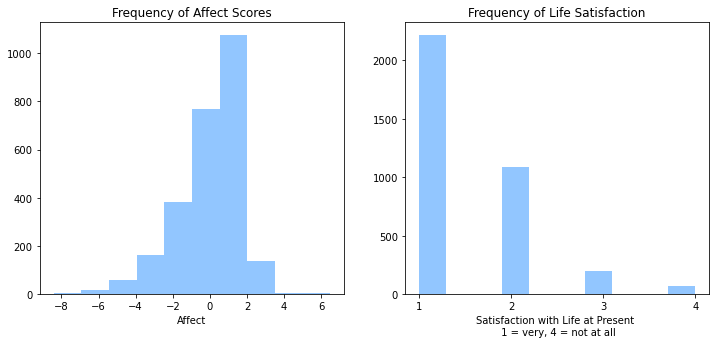

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

axs[0].hist(affect)
axs[0].set_title('Frequency of Affect Scores')
axs[0].set(xlabel = 'Affect')

axs[1].hist(life_sat)
axs[1].set_title('Frequency of Life Satisfaction')
axs[1].set(xlabel = 'Satisfaction with Life at Present \n 1 = very, 4 = not at all', xticks = range(1,5))

plt.show()

In [18]:
# showing age differences
def return_means(ages,df,var):
    age_means = {}
    age_cis = {}
    for i,age in enumerate(ages):
        try:
            if age < 30:
                if '20-29' not in age_means:
                    age_means['20-29'] = []
                age_means['20-29'].append(df[var][i])
            elif age < 40:
                if '30-39' not in age_means:
                    age_means['30-39'] = []
                age_means['30-39'].append(df[var][i])
            elif age < 50:
                if '40-49' not in age_means:
                    age_means['40-49'] = []
                age_means['40-49'].append(df[var][i])
            elif age < 60:
                if '50-59' not in age_means:
                    age_means['50-59'] = []
                age_means['50-59'].append(df[var][i])    
            elif age < 70:
                if '60-69' not in age_means:
                    age_means['60-69'] = []
                age_means['60-69'].append(df[var][i])    
            else:
                if '70-79' not in age_means:
                    age_means['70-79'] = []
                age_means['70-79'].append(df[var][i])
        except KeyError:
            pass

    for key in age_means:
        age_cis[key] = 2*(np.std(age_means[key])/np.sqrt(len(age_means[key])))
        age_means[key] = np.mean(age_means[key])
        
    return age_means, age_cis

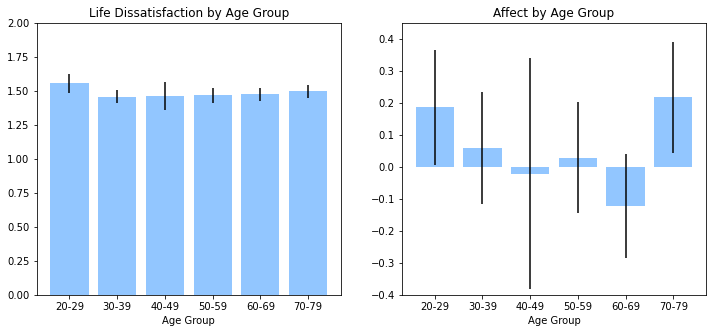

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

sat_means, sat_cis = return_means(x_sat['RA1PRAGE'], x_sat, 'life_sat')
sorted_dict = sorted(sat_means.items())
x, y = zip(*sorted_dict)

axs[0].bar(x,y, yerr = sat_cis.values())
axs[0].set_title('Life Dissatisfaction by Age Group')
axs[0].set(xlabel = 'Age Group', ylim = (0,2))

affect_means, affect_cis = return_means(x_affect['RA1PRAGE'], x_affect, 'affect')
sorted_dict2 = sorted(affect_means.items())
x, y = zip(*sorted_dict2)

axs[1].bar(x,y, yerr = affect_cis.values())
axs[1].set_title('Affect by Age Group')
axs[1].set(xlabel = 'Age Group', ylim = (-.4,.45))

plt.show()

In [20]:
for entry in sorted_dict:
    print(entry)

('20-29', 1.5555555555555556)
('30-39', 1.4579439252336448)
('40-49', 1.4596443228454172)
('50-59', 1.4669540229885059)
('60-69', 1.4753661784287617)
('70-79', 1.4963855421686747)


We can see from the bar plot that people in their twenties tend to have higher dissatisfaction with their life at present, but for other age groups, satisfaction with their current life was roughly the same at around 1.46 (although people in their 70's tended to report lower life satisfaction level.)

It also might be iteresting to check if the month in which people were surveyed was related to higher or lower degrees of satisfaction or affect. Since there is no reason to think that happier people would be interviewed in different months than less happy people, any relationship here might be capturing a seasonal effect on happiness. Indeed, in the next figure, we do see some variation, with there being a statistically significant ($\alpha = 0.05$) difference between some months. Given that we are making many comparisons, however, it is very likely that the differences are still due to random chance.

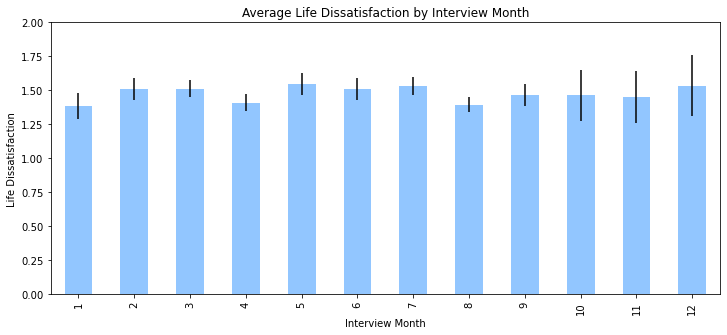

In [21]:
# plot dissatisfaction by interview month
months = x_sat.groupby(['RA1PIDATE_MO'])['life_sat'].mean()

#make confidence intervals for the bars.
sd = x_sat.groupby(['RA1PIDATE_MO'])['life_sat'].std().values
n = x_sat.groupby(['RA1PIDATE_MO'])['life_sat'].count().values
cis = 2*(sd/np.sqrt(n))

months.plot(kind='bar', title='Average Life Dissatisfaction by Interview Month', ylabel='Life Dissatisfaction',
         xlabel='Interview Month', figsize=(12, 5), yerr = cis)
plt.ylim((0,2))
plt.show()

In the next figure, we see the relationship between interview month and affect, and the differences are much more pronounced, but the confidence intervals are much wider as well. 

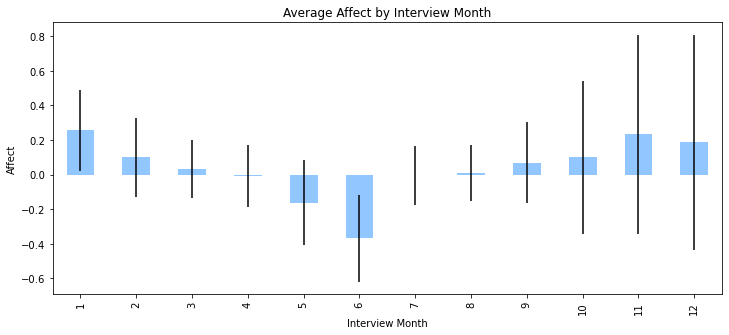

In [22]:
months = x_affect.groupby(['RA1PIDATE_MO'])['affect'].mean()

#make confidence intervals (2 x standard error)
sd = x_affect.groupby(['RA1PIDATE_MO'])['affect'].std().values

n = x_affect.groupby(['RA1PIDATE_MO'])['affect'].count().values
cis = 2*(sd/np.sqrt(n))

months.plot(kind='bar', title='Average Affect by Interview Month', ylabel='Affect',
         xlabel='Interview Month', figsize=(12, 5), yerr = cis)
plt.show()

Finally we can see some comparisons of gender. While men and women report similar levels of life dissastisfaction, women tended to report feeling more negative emotions than men.

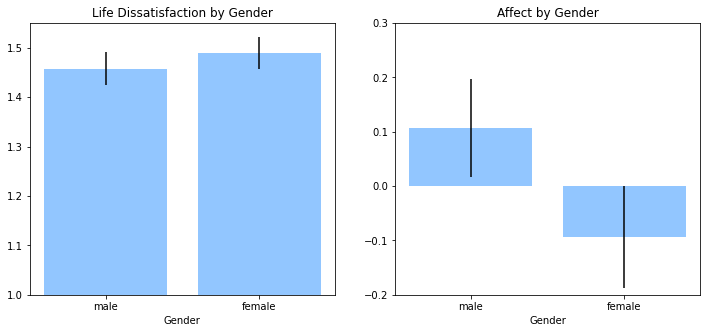

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

gender = x_sat.groupby(['RA1PRSEX'])['life_sat'].mean()
sd = x_sat.groupby(['RA1PRSEX'])['life_sat'].std().values
n = x_sat.groupby(['RA1PRSEX'])['life_sat'].count().values
cis = 2*(sd/np.sqrt(n))

axs[0].bar(['male','female'],gender.values, yerr = cis)
axs[0].set_title('Life Dissatisfaction by Gender')
axs[0].set(xlabel = 'Gender', ylim = (1,1.55))

gender = x_affect.groupby(['RA1PRSEX'])['affect'].mean()
sd = x_affect.groupby(['RA1PRSEX'])['affect'].std().values
n = x_affect.groupby(['RA1PRSEX'])['affect'].count().values
cis = 2*(sd/np.sqrt(n))

axs[1].bar(['male','female'],gender.values, yerr = cis)
axs[1].set_title('Affect by Gender')
axs[1].set(xlabel = 'Gender', ylim = (-.2,.3))

plt.show()

<a name = finalcleaning></a><h3>3.2 Final Cleaning</h3>
At the final stage of cleaning, and in preparation for fitting the models, I drop the variables that I used to create the targets and other variables that Margolis et al. indicate are very conceptually similar to the targets. This yields the final dimensions of 2,610 x 2,287 for the dataset that will be used to predict affect and 3,572 x 2,325 for the dataset that will be used to predict life satisfaction. There are still a very large number of predictors, and dimensionality reduction might be fruitful here, but first I want to see how th models perform with no dimensionality reduction.

In [24]:
# create a list of the variables that either are being used to construct the labels or are highly related to the labels (like the life rating items)
list_of_labels = ['MRCOMBWT', 'RA1PG1', 'RA1SPWBS1', 'RA1SPWBS2','RA1SPOSAF', 'RA1SNEGPA','RA1SNEGAF', 'RA1SA21', 'RA1SA23', 'RA1SPOSPA', 'affect', 'life_sat']
for n in range(1,4):
    list_of_labels.append(f'RA1SR{n}')

for l in letters:
    list_of_labels.append(f'RA1SA20{l}')
for l in letters[:-1]:
    list_of_labels.append(f'RA1SA22{l}')

In [25]:
affect = x_affect['affect']
life_sat = x_sat['life_sat']

for col in list_of_labels:
    try:
        x_affect = x_affect.drop(col, axis = 1)
    except KeyError:
        pass
    try:
        x_sat = x_sat.drop(col, axis = 1)
    except KeyError:
        pass

In [26]:
print(x_affect.shape)
print(x_sat.shape)

(2610, 2287)
(3572, 2325)


I also want to save the column names so that when I perform PCA, I can compare factor loadings for the features.

In [27]:
affect_features = x_affect.columns
sat_features = x_sat.columns
print(len(affect_features))
print(len(sat_features))

2287
2325


<a name = impute></a><h3>3.3 KNN Imputation</h3>
There are still many NA's in the data that need to be handled. Dropping all columns with NA's is not possible, as it results in all rows being dropped. If there were far fewer features, I might go through by hand and decide on a case by case basis. Since this is not feasible to do for more than two thousand features, I will instead impute values for the remaining NAs. Once again I follow the method used by Margolis et al. for this data and use KNN imputation. This will impute each NA with the majority value of the observation's five nearest neighbors.

In [28]:
# impute missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
x_affect = imputer.fit_transform(x_affect)
x_sat = imputer.fit_transform(x_sat)

<a name = model></a><h2>4. Model Building</h2>

Now it is finally time to do the model building and testing. I will do linear regression, support vector regression, decision tree regression, and a random forest regression and compare the mean square errors (MSEs). 

First I split the training and validation sets, holding out 15% of the dataset for validation.

In [29]:
# predict affect
x_train, x_val, y_train, y_val = train_test_split(x_affect,affect,test_size=.15)

In [30]:
print('x_train: ',x_train.shape)
print('y_train: ',y_train.shape)

x_train:  (2218, 2287)
y_train:  (2218,)


<a name = lr></a><h3>4.1 Linear Regression</h3>

In [31]:
# linear regression
lm = LinearRegression().fit(x_train, y_train)

I fit the model on the training data. I am also going to make lists to save the MSEs and R-squared values for each model to allow for easy plotting later.

In [32]:
MSE = []
R_squared = []

# baseline model for comparison - just guessing the y-train mean
MSE.append(np.mean((np.mean(y_train)- y_val)**2))
R_squared.append(0)

print('Baseline: ',np.mean((np.mean(y_train)- y_val)**2))

Baseline:  3.2077562377644964


In [33]:
yhat = lm.predict(x_val)
mse = np.mean((yhat - y_val)**2)

print("R2 = ",metrics.r2_score(y_val, yhat))
print("MSE = ", mse)

R2 =  -43.17120962708345
MSE =  141.60329700500722


Both the R2 and the MSE are shockingly bad. They are the worst I have ever seen, in fact. Either there is something seriously wrong with the underlying data or the model is massively overfitting. To explore if the model is overfitting, I will instead run ridge regression, using hyperparameter tuning for the $\alpha$ coefficient. I will not save the $R^2$ or $MSE$ for this model - let's pretend this never happened (also, plotting these values will distort the final graphs, making the differences between other models look negligible).

It appears that overfitting in fact did cause the really bad results for the simple linear regression. Setting $\alpha$ to be very high results in less overfitting. Here I tune the hyperparameter and save the best results to my $MSE$ and $R^2$ lists.

In [34]:
# ridge regression
alphas = [10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000, 100000]
lowest_mse = np.inf
best_r2 = -np.inf

for a in alphas:
    ridge = Ridge(alpha=a, solver = 'svd').fit(x_train, y_train)
    yhat = ridge.predict(x_val)
    mse = np.mean((yhat - y_val)**2)
    print('alpha =', a,' mse =', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)

# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

alpha = 0.001  mse = 70.19031739370631
alpha = 0.01  mse = 31.54920753874776
alpha = 0.1  mse = 14.815084792697624
alpha = 1.0  mse = 6.6318627434094095
alpha = 10  mse = 3.1243500191264735
alpha = 100  mse = 1.7681531465743692
alpha = 1000  mse = 1.2480467507888304
alpha = 10000  mse = 1.1665135084885159
alpha = 100000  mse = 1.3136567654449165


<a name = svr></a><h3>4.2 Support Vector Regression</h3>

In [35]:
kernels = ['poly', 'rbf', 'sigmoid']
cs = [10e-4, 10e-3, 10e-2, 10e-1, 10, 10e+1, 10e+2]

mses = []
lowest_mse = np.inf
best_r2 = -np.inf

for k in kernels:
    for c in cs:
        svr = SVR(kernel = k, C = c).fit(x_train, y_train)
        yhat = svr.predict(x_val)
        mse = np.mean((yhat - y_val)**2)
        print('kernel:', k, ' C:', c, ' mse =', mse)
        if mse < lowest_mse:
            lowest_mse = mse
            best_r2 = metrics.r2_score(y_val, yhat)
            
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

kernel: poly  C: 0.001  mse = 3.300664146093158
kernel: poly  C: 0.01  mse = 3.2075971733483053
kernel: poly  C: 0.1  mse = 3.0212190118208238
kernel: poly  C: 1.0  mse = 2.895278294577993
kernel: poly  C: 10  mse = 2.8992258062386758
kernel: poly  C: 100.0  mse = 3.448445484672052
kernel: poly  C: 1000.0  mse = 5.260770947856072
kernel: rbf  C: 0.001  mse = 3.3016429874332993
kernel: rbf  C: 0.01  mse = 3.2211161578599694
kernel: rbf  C: 0.1  mse = 3.0237735757487187
kernel: rbf  C: 1.0  mse = 2.9032037670373687
kernel: rbf  C: 10  mse = 2.835725942473785
kernel: rbf  C: 100.0  mse = 3.0925263441437263
kernel: rbf  C: 1000.0  mse = 3.821397466176956
kernel: sigmoid  C: 0.001  mse = 3.309585401683824
kernel: sigmoid  C: 0.01  mse = 3.2663708630682415
kernel: sigmoid  C: 0.1  mse = 3.103771881617225
kernel: sigmoid  C: 1.0  mse = 22.208518265060967
kernel: sigmoid  C: 10  mse = 2365.700404024564
kernel: sigmoid  C: 100.0  mse = 232910.81314290795
kernel: sigmoid  C: 1000.0  mse = 233405

<a name = knr></a><h3>4.3 K-Nearest Regression</h3>

In [36]:
# knn
ks = range(1,11)
lowest_mse = np.inf
best_r2 = -np.inf

for k in ks:
    neigh = knr(n_neighbors=k)
    neigh.fit(x_train, y_train)
    yhat = neigh.predict(x_val)
    mse = np.mean((yhat - y_val)**2)
    print('K:',k, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

K: 1  mse =  5.358239470774057
K: 2  mse =  4.099884949883187
K: 3  mse =  3.7472012565310817
K: 4  mse =  3.5074367581415777
K: 5  mse =  3.2830101961653786
K: 6  mse =  3.2210133619956047
K: 7  mse =  3.173923076279469
K: 8  mse =  3.1698516677388393
K: 9  mse =  3.130166605082774
K: 10  mse =  3.152270714358724


<a name = trees></a><h3>4.4 Decision Tree and Random Forest Regression</h3>

In [37]:
# decision tree regression
depths = range(2,10)
lowest_mse = np.inf
best_r2 = -np.inf

for d in depths:
    tree = DecisionTreeRegressor(max_depth= d)
    tree.fit(x_train, y_train)
    yhat = tree.predict(x_val)
    mse = np.mean((yhat - y_val)**2)
    print('Depth:',d, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

Depth: 2  mse =  1.8513752093145468
Depth: 3  mse =  1.6291865877691414
Depth: 4  mse =  1.3548944657592008
Depth: 5  mse =  1.400712354977469
Depth: 6  mse =  1.4312634580523538
Depth: 7  mse =  1.8302865603960061
Depth: 8  mse =  1.7889848967078215
Depth: 9  mse =  1.9422242835739163


In [38]:
# random forest
depths = range(2,10)
lowest_mse = np.inf
best_r2 = -np.inf

for d in depths:
    forest = RandomForestRegressor(max_depth=d)
    forest.fit(x_train, y_train)
    yhat = forest.predict(x_val)
    mse = np.mean((yhat - y_val)**2)
    print('Depth:',d, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

Depth: 2  mse =  1.478043610124904
Depth: 3  mse =  1.1802603972608872
Depth: 4  mse =  1.1040571880074423
Depth: 5  mse =  1.0350708790505356
Depth: 6  mse =  0.9980750837916423
Depth: 7  mse =  0.9627428848423663
Depth: 8  mse =  0.9536920298364019
Depth: 9  mse =  0.9687611632738049


In [39]:
models = ['Baseline', 'Ridge Regression (raw)', 'SVR (raw)', 'KN (raw)', 'Decision Tree (raw)', 'Random Forest (raw)']

pd.DataFrame({'Model':models, 'R2': R_squared, 'MSE': MSE})

,Model,R2,MSE
0,Baseline,0.000000,3.207756
1,Ridge Regression (raw),0.636122,1.166514
2,SVR (raw),0.115434,2.835726
3,KN (raw),0.023587,3.130167
4,Decision Tree (raw),0.577359,1.354894
5,Random Forest (raw),0.702509,0.953692


So far, the random forest (with a depth of 8) does the best, although ridge regression is a close second. I turn next to trying to reduce the number of dimensions. While this should not be expected to improve model $MSE$ or $R^2$ (because dimensionality reduction throws out information), it is useful as a comparison, given the high dimensionality of this data. 

<a name = dim></a><h2>5. Dimensionality Reduction and Modeling</h2>
The high dimensionality of the dataset and the relatively bad performance of some models indicates that it might be a good idea to try to reduce the number of dimensions.

<a name = pca></a><h3>5.1 Principal Components Analysis</h3>
I set the number of components so that 95% of the variance in the training data is captured. This results in 20 principle componenets, a reduction by a factor of 100.

In [40]:
# dimensionality reduction
pca = PCA(n_components = .95, svd_solver='full')

In [41]:
x_train_reduced = pca.fit_transform(x_train)
print('Training set reduced to size', x_train_reduced.shape)
print('Explained variances: ', pca.explained_variance_ratio_)

Training set reduced to size (2218, 20)
Explained variances:  [0.33140543 0.14529231 0.09648842 0.05061703 0.04053333 0.03775534
 0.03343631 0.02988627 0.02759186 0.02146829 0.01968525 0.01752413
 0.01643596 0.01509598 0.0144975  0.01335664 0.01314817 0.0118191
 0.01005833 0.00701844]


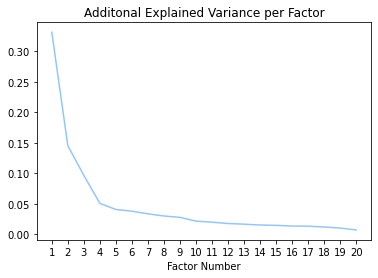

In [42]:
plt.plot(pca.explained_variance_ratio_)
plt.xticks(range(20), [x+1 for x in range(20)])
plt.title('Additonal Explained Variance per Factor')
plt.xlabel('Factor Number')
plt.show()

In [43]:
x_val_reduced = pca.transform(x_val)
x_val_reduced.shape

(392, 20)

In [44]:
# get factor loadings
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix.shape

(2287, 20)

In [45]:
# save the five variables that have the greatest loadings for each factor
top_five_loadings = {}

for col in range(loading_matrix.shape[1]):
    top_five_loadings[f'x{col+1}'] = {}
    top_five = sorted(loading_matrix[:,col], reverse = True)[:5]
    for row in range(loading_matrix.shape[0]):
        if loading_matrix[row,col] in top_five:
            top_five_loadings[f'x{col+1}'][f'{affect_features[row]}'] = loading_matrix[row,col]
        

In [46]:
for i in range(1,4):
    print(f'x[{i}]:',top_five_loadings[f'x{i}'])

x[1]: {'RA1SH61C': 41153210.83777839, 'RA1SH61D': 41292532.48741867, 'RA1SH61G': 40696564.01223667, 'RA1SH61H': 38356678.87528763, 'RA1SH61I': 39933395.17060935}
x[2]: {'RA1SI13B': 19417593.983159203, 'RA1SI13D': 19568139.75008913, 'RA1SI13E': 19939572.55003187, 'RA1SI13G': 19926912.583535105, 'RA1SI14E': 18998176.624569993}
x[3]: {'RA1SH21': 10472046.73495537, 'RA1SH61C': 3803137.7726703207, 'RA1SH61G': 4085335.6136326417, 'RA1SH61I': 4387584.967042589, 'RA1SI13G': 4011605.786051844}


Above I printed the features that have the greatest loading on the first three factors. Looking up the variables in the codebook shows that all of the variables have to do with money. Indeed, money-related variables loaded the most heavily on all of the factors. The sheer number of variables makes further exploration of factor loadings implausible right now, but it could be an avenue for future research.

<a name = pcr></a><h3>5.2 Principal Components Regression</h3>
Now it is time to see if reducing the number of dimensions from more than two thousand to only 16 helps any of the models improve. Once again, I run linear regression, support vector regression, decision tree, and random forest models, and save the respective R2 and MSE values.

In [47]:
pcr = LinearRegression().fit(x_train_reduced, y_train)

In [48]:
yhat = pcr.predict(x_val_reduced)
mse = np.mean((yhat - y_val)**2)

MSE.append(mse)
R_squared.append(metrics.r2_score(y_val, yhat))

print("R2 = ",metrics.r2_score(y_val, yhat))
print("MSE = ", mse)

R2 =  0.0929632548570255
MSE =  2.9077626513126673


Reducing the number of dimensions did greatly improve the performance of unregularized linear regression, although with an R2 of .03, it is still among the worst of the models.

In [49]:
# ridge regression
alphas = [10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000, 100000]
lowest_mse = np.inf
best_r2 = -np.inf

for a in alphas:
    ridge = Ridge(alpha=a, solver = 'svd').fit(x_train_reduced, y_train)
    yhat = ridge.predict(x_val_reduced)
    mse = np.mean((yhat - y_val)**2)
    print('alpha =', a,' mse =', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)

# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

alpha = 0.001  mse = 2.907762651312668
alpha = 0.01  mse = 2.907762651312668
alpha = 0.1  mse = 2.907762651312668
alpha = 1.0  mse = 2.907762651312668
alpha = 10  mse = 2.907762651312668
alpha = 100  mse = 2.907762651312668
alpha = 1000  mse = 2.9077626513126686
alpha = 10000  mse = 2.9077626513126686
alpha = 100000  mse = 2.9077626513126704


The MSEs for ridge regression are not noticeably affect by regularization and all of the models are basically identical to the unregularized regression, which makes sense as there is little prospect for overfitting with the greatly reduced number of predictor variables.

<a name = pcsvr></a><h3>5.3 Support Vector Regression</h3>

In [50]:
kernels = ['poly', 'rbf', 'sigmoid']
cs = [10e-4, 10e-3, 10e-2, 10e-1, 10, 10e+1, 10e+2]

mses = []
lowest_mse = np.inf
best_r2 = -np.inf

for k in kernels:
    for c in cs:
        svr = SVR(kernel = k, C = c).fit(x_train_reduced, y_train)
        yhat = svr.predict(x_val_reduced)
        mse = np.mean((yhat - y_val)**2)
        print('kernel:', k, ' C:', c, ' mse =', mse)
        if mse < lowest_mse:
            lowest_mse = mse
            best_r2 = metrics.r2_score(y_val, yhat)
            
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

kernel: poly  C: 0.001  mse = 3.303619602088643
kernel: poly  C: 0.01  mse = 3.2546067608260674
kernel: poly  C: 0.1  mse = 3.133046967948619
kernel: poly  C: 1.0  mse = 3.139153562225558
kernel: poly  C: 10  mse = 3.691016960678039
kernel: poly  C: 100.0  mse = 6.891891352722135
kernel: poly  C: 1000.0  mse = 29.511633906564867
kernel: rbf  C: 0.001  mse = 3.292316829285247
kernel: rbf  C: 0.01  mse = 3.181889904009942
kernel: rbf  C: 0.1  mse = 2.985884595287242
kernel: rbf  C: 1.0  mse = 2.895345537061214
kernel: rbf  C: 10  mse = 2.997025428205977
kernel: rbf  C: 100.0  mse = 3.5200139254580862
kernel: rbf  C: 1000.0  mse = 4.296678590261603
kernel: sigmoid  C: 0.001  mse = 3.286813880154167
kernel: sigmoid  C: 0.01  mse = 3.1604431996384634
kernel: sigmoid  C: 0.1  mse = 5.093981763040469
kernel: sigmoid  C: 1.0  mse = 320.1779284009933
kernel: sigmoid  C: 10  mse = 32993.88271784296
kernel: sigmoid  C: 100.0  mse = 3323260.244452476
kernel: sigmoid  C: 1000.0  mse = 332701550.715

<a name = pcknr></a><h3>5.4 K-Nearest Regression</h3>

In [51]:
ks = range(1,11)
lowest_mse = np.inf
best_r2 = -np.inf

for k in ks:
    neigh = knr(n_neighbors=k)
    neigh.fit(x_train_reduced, y_train)
    yhat = neigh.predict(x_val_reduced)
    mse = np.mean((yhat - y_val)**2)
    print('K:',k, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

K: 1  mse =  4.873040511993688
K: 2  mse =  4.229740503138216
K: 3  mse =  3.824409142224804
K: 4  mse =  3.6073720525495583
K: 5  mse =  3.5262995042931435
K: 6  mse =  3.3226449761307495
K: 7  mse =  3.255708419553715
K: 8  mse =  3.2361505206836667
K: 9  mse =  3.204689844246684
K: 10  mse =  3.1270832447332015


<a name = pctrees></a><h3>5.5 Decision Tree and Random Forest</h3>

In [52]:
depths = range(2,10)
lowest_mse = np.inf
best_r2 = -np.inf

for d in depths:
    pcatree = DecisionTreeRegressor(max_depth= d)
    pcatree.fit(x_train_reduced, y_train)
    yhat = pcatree.predict(x_val_reduced)
    mse = np.mean((yhat - y_val)**2)
    print('Depth:',d, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

Depth: 2  mse =  2.950619596728522
Depth: 3  mse =  2.9864141898893637
Depth: 4  mse =  3.1249778833474564
Depth: 5  mse =  3.1680783886280577
Depth: 6  mse =  3.2249349675584553
Depth: 7  mse =  3.290823346435697
Depth: 8  mse =  3.3850990812949973
Depth: 9  mse =  3.6758162277580753


In [53]:
# random forest
depths = range(2,10)
lowest_mse = np.inf
best_r2 = -np.inf

for d in depths:
    pcaforest = RandomForestRegressor(max_depth=d)
    pcaforest.fit(x_train_reduced, y_train)
    yhat = pcaforest.predict(x_val_reduced)
    mse = np.mean((yhat - y_val)**2)
    print('Depth:',d, ' mse = ', mse)
    if mse < lowest_mse:
        lowest_mse = mse
        best_r2 = metrics.r2_score(y_val, yhat)
        
# save the results of the best model 
MSE.append(lowest_mse)
R_squared.append(best_r2)

Depth: 2  mse =  2.9341385991907143
Depth: 3  mse =  2.9394913384459893
Depth: 4  mse =  2.92714788160833
Depth: 5  mse =  2.953099127402406
Depth: 6  mse =  2.990810381533756
Depth: 7  mse =  2.9825283575630763
Depth: 8  mse =  3.0288192603490685
Depth: 9  mse =  2.9814884198333322


<a name = conclusion></a><h2>6. Final Results and Conclusion</h2>

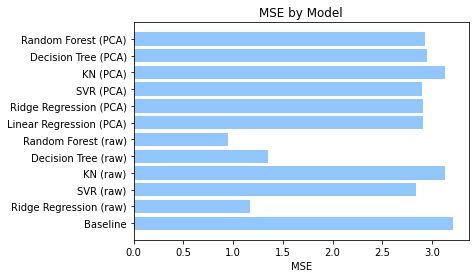

In [54]:
model_names = ['Baseline', 'Ridge Regression (raw)', 'SVR (raw)', 'KN (raw)', 'Decision Tree (raw)', 'Random Forest (raw)', 'Linear Regression (PCA)', 'Ridge Regression (PCA)', 'SVR (PCA)', 'KN (PCA)', 'Decision Tree (PCA)', 'Random Forest (PCA)']
plt.barh(model_names, MSE)
plt.title('MSE by Model')
plt.xlabel('MSE')
plt.show()

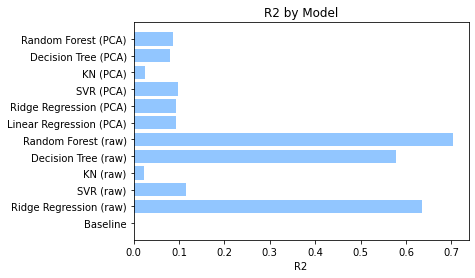

Random Forest: R2: 0.7025088295218666  MSE:  0.9536920298364019


In [55]:
plt.barh(model_names, R_squared)
plt.title('R2 by Model')
plt.xlabel('R2')
plt.show()

print('Random Forest: R2:',max(R_squared), ' MSE: ',(min(MSE)))

The results are clear - principal component analysis here only made model performance worse (with the exception of linear regression), and while it did result in faster run times (not pictured), the small number of observations made this concern unimportant. Random forest had the best performance, with ridge regression a close second.

These results only partially replicate the findings of Margolis et al. Those authors found that ridge regression had very good performance, but random forest did not perform well. There are several reasons for why our results partially diverge - they performed a significant amoutn of hand-engineering, using their domain knowledge to remove variables or combine variables into scales, and they combined this data set with another MIDUS dataset. The key takeaway from our diverging results is that the choice made in hand engineering variables may have dramatic effects on the performance of models, and robust tests of results under many different choices should be undertaken before concluding that machine learning models offer no improvement over linear regression.

Finally, because a random forest model was the best performing model, I wil display the results from a random forest regression. The best performance was with a maximum depth of eight, which is too much to show with a visualization. Instead, below I plot a tree from a random forest with a depth of four.

In [56]:
forest = RandomForestRegressor(max_depth=4)
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=4)

In [57]:
viz = dtreeviz(forest.estimators_[0], x_train, y_train,
               feature_names=affect_features,
               title="1st Tree from Random Forest")

In [58]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [59]:
viz

The variables have unclear names, but here are some of the most important variables that this decision tree used:

RA1SPWBE2 - Environmental Mastery scale (7 item)

RA1SESTEE - self-esteem

RA1PA84A - how long worry lasts on days you worry

RA1SF7K - mood often fluctuates

RA1SSATIS2 - 6-item life satisfaction measure

RA1SF4B - feel helpless to deal with problems of life

RA1SPESSI - pessimism

RA1SA10D - irritability frequency

RA1SF1L - feel positive/confident about self

RA1PDEPRE - depressed affect

RA1SSATIS - 5-item life satisfaction

In [ ]:
forest = RandomForestRegressor(max_depth=8)
forest.fit(x_train, y_train)

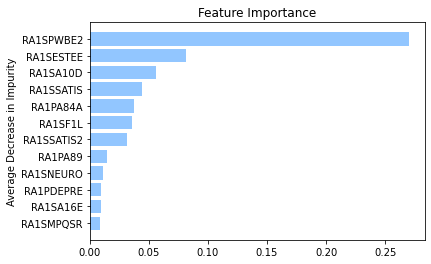

In [62]:
imp = forest.feature_importances_

forest_importances = pd.Series(imp, index=affect_features)

v = forest_importances.sort_values(ascending = False).values[:12]
k = forest_importances.sort_values(ascending = False).keys()[:12]

fig, ax = plt.subplots()
plt.barh(k, v)
ax.set_title("Feature Importance")
ax.set_ylabel("Average Decrease in Impurity")
plt.gca().invert_yaxis()
plt.show()

RA1SPWBE2 - Environmental Mastery scale (7 item)

RA1SESTEE - self-esteem

RA1SA10D - irritability frequency

RA1SSATIS - 5-item life satisfaction

RA1PA84A - how long worry lasts on days you worry

RA1SF1L - feel positive/confident about self

RA1SSATIS2 - 6-item life satisfaction measure

RA1PA89 - how much worry interferes with your life

RA1SNEURO - neuroticism

RA1PDEPRE - depressed affect

RA1SA16E - pain interfered with enjoyment of life last week

RA1SMPQSR - reactivity (personality trait)

Many of the variables are in fact highly related to the target variable, which makes it surprising that the many of the other models did so badly.

All in all, the random forest model yielded plausible results and showed some performance improvement over ridge regression.

<a name = refs></a><h2>7. References</h2>

Margolis, Seth, Elder, Jacob, Hughes, Brent, Lyubomirsky, Sonja. (2021). What Are the Most Important Predictors of Subjective Well-Being? Insights     
>  From Machine Learning and Linear Regression Approaches on the MIDUS Datasets. 10.31234/osf.io/ugfjs. 

Ryff, Carol, Almeida, David M., Ayanian, John Z., Binkley, Neil, Carr, Deborah S., Coe, Christopher, … Williams, David R. Midlife in the United States 
> (MIDUS Refresher 1), 2011-2014. Inter-university Consortium for Political and Social Research [distributor], 2017-11-20. 
> https://doi.org/10.3886/ICPSR36532.v3